# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [12]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [13]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):

        # dummy assignment until this function is filled in
        x=F.relu(self.fc1(x))
        means = torch.randn(x.shape[0], 20).to(device)
        log_variances = torch.randn(x.shape[0], 20).to(device)
        means=self.fc2 (x)
        log_variances=self.fc22 (x)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):

        # dummy assignment until this function is filled in
        embedding = torch.randn(means.shape[0], 20).to(device)
        var = torch.exp(0.5*log_variances) 
        eps = torch.randn_like(var) 
        embedding = means + (eps * var)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):

        # dummy assignment until this function is filled in
        z=F.relu(self.fc3(z))
        probabilties = torch.rand(z.shape[0],784).to(device)
        probabilties=torch.sigmoid(self.fc4(z))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        # dummy assignment until this function is filled in
        probabilties = torch.rand(x.shape[0],20).to(device)
        means = torch.randn(x.shape[0], 20).to(device)
        log_variances = torch.randn(x.shape[0], 20).to(device)
        means, log_variances=self.encode(x.view(-1, 784))
        z= self.reparameterize(means,log_variances)
        probabilties=self.decode(z)
        return probabilties, means, log_variances

# Loss Functions

In [14]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    # dummy assignment until this function is filled in
    total_loss = 0
    BCE = 0
    BCE=dae_loss_function(reconstructed_x, x)
    total_loss=BCE-0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    return total_loss, BCE


# Training

In [15]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):

    # dummy assignment until this function is filled in
    average_train_loss = 0
    average_train_BCE = 0
    
    train_BCE = 0
    train_loss=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch,means,log_variances= model(data)
        loss_vae,loss_bce = vae_loss_function(recon_batch, data, means, log_variances)
        
        loss_vae.backward()
        

        train_loss += loss_vae.item()
        train_BCE +=  loss_bce.item()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss_bce.item() / len(data)))


    average_train_BCE = train_BCE / len(train_loader.dataset)
    average_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))

    return average_train_loss, average_train_BCE



# Testing

In [16]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):

    # dummy assignment until this function is filled in
    average_test_loss = 0
    average_test_BCE = 0
    model.eval()
    test_BCE = 0
    test_vae=0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch,means,log_variances = model(data)
           
            test_vae1,test_BCE1 = vae_loss_function(recon_batch, data,means,log_variances)
            test_vae+=test_vae1
            test_BCE+=test_BCE1
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    average_test_loss=test_vae/len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.835449
Train Epoch: 1 [12800/60000 (21%)]	Loss: 153.068787
Train Epoch: 1 [25600/60000 (43%)]	Loss: 121.104584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 98.463783
Train Epoch: 1 [51200/60000 (85%)]	Loss: 89.377045
====> Epoch: 1 Average loss: 129.8660
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


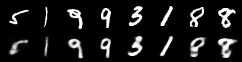

====> Test set loss: 87.6525
Sample of generated images


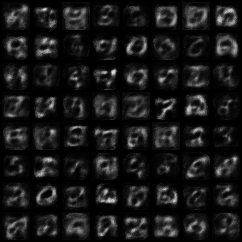



Train Epoch: 2 [0/60000 (0%)]	Loss: 90.036896
Train Epoch: 2 [12800/60000 (21%)]	Loss: 83.780357
Train Epoch: 2 [25600/60000 (43%)]	Loss: 82.951859
Train Epoch: 2 [38400/60000 (64%)]	Loss: 82.895447
Train Epoch: 2 [51200/60000 (85%)]	Loss: 81.246277
====> Epoch: 2 Average loss: 83.1964
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


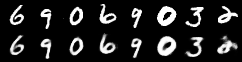

====> Test set loss: 78.6528
Sample of generated images


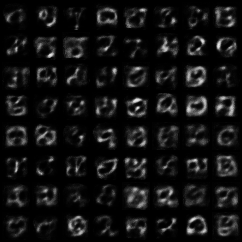



Train Epoch: 3 [0/60000 (0%)]	Loss: 81.467110
Train Epoch: 3 [12800/60000 (21%)]	Loss: 77.860489
Train Epoch: 3 [25600/60000 (43%)]	Loss: 73.848801
Train Epoch: 3 [38400/60000 (64%)]	Loss: 75.685898
Train Epoch: 3 [51200/60000 (85%)]	Loss: 77.501266
====> Epoch: 3 Average loss: 77.3225
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


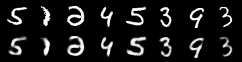

====> Test set loss: 75.0070
Sample of generated images


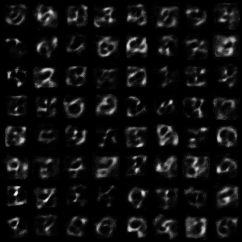



Train Epoch: 4 [0/60000 (0%)]	Loss: 78.236725
Train Epoch: 4 [12800/60000 (21%)]	Loss: 73.809586
Train Epoch: 4 [25600/60000 (43%)]	Loss: 73.455139
Train Epoch: 4 [38400/60000 (64%)]	Loss: 74.789078
Train Epoch: 4 [51200/60000 (85%)]	Loss: 74.603760
====> Epoch: 4 Average loss: 74.4799
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


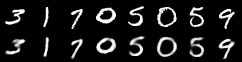

====> Test set loss: 72.8279
Sample of generated images


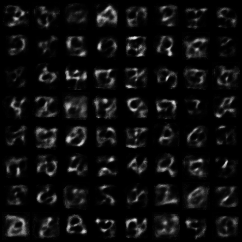



Train Epoch: 5 [0/60000 (0%)]	Loss: 72.436981
Train Epoch: 5 [12800/60000 (21%)]	Loss: 72.863022
Train Epoch: 5 [25600/60000 (43%)]	Loss: 71.294411
Train Epoch: 5 [38400/60000 (64%)]	Loss: 69.927002
Train Epoch: 5 [51200/60000 (85%)]	Loss: 76.451416
====> Epoch: 5 Average loss: 72.6417
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


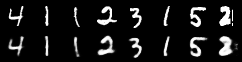

====> Test set loss: 71.4207
Sample of generated images


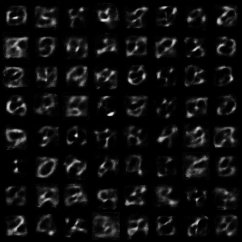



Train Epoch: 6 [0/60000 (0%)]	Loss: 74.007477
Train Epoch: 6 [12800/60000 (21%)]	Loss: 69.816147
Train Epoch: 6 [25600/60000 (43%)]	Loss: 74.996353
Train Epoch: 6 [38400/60000 (64%)]	Loss: 70.295029
Train Epoch: 6 [51200/60000 (85%)]	Loss: 72.883476
====> Epoch: 6 Average loss: 71.3234
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


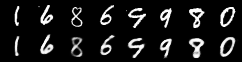

====> Test set loss: 70.4042
Sample of generated images


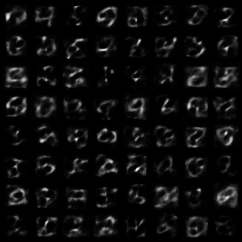



Train Epoch: 7 [0/60000 (0%)]	Loss: 69.761017
Train Epoch: 7 [12800/60000 (21%)]	Loss: 70.535797
Train Epoch: 7 [25600/60000 (43%)]	Loss: 65.477188
Train Epoch: 7 [38400/60000 (64%)]	Loss: 70.135406
Train Epoch: 7 [51200/60000 (85%)]	Loss: 70.032227
====> Epoch: 7 Average loss: 70.3174
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


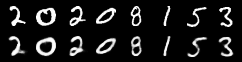

====> Test set loss: 69.5435
Sample of generated images


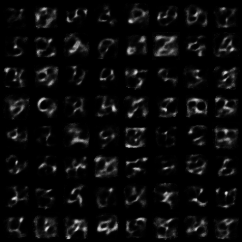



Train Epoch: 8 [0/60000 (0%)]	Loss: 69.179771
Train Epoch: 8 [12800/60000 (21%)]	Loss: 67.936615
Train Epoch: 8 [25600/60000 (43%)]	Loss: 70.302979
Train Epoch: 8 [38400/60000 (64%)]	Loss: 71.574844
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.188629
====> Epoch: 8 Average loss: 69.5034
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


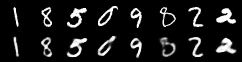

====> Test set loss: 68.8894
Sample of generated images


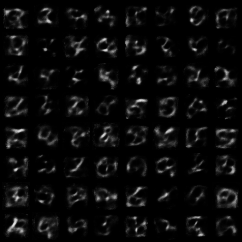



Train Epoch: 9 [0/60000 (0%)]	Loss: 69.353821
Train Epoch: 9 [12800/60000 (21%)]	Loss: 68.925056
Train Epoch: 9 [25600/60000 (43%)]	Loss: 68.954086
Train Epoch: 9 [38400/60000 (64%)]	Loss: 67.369270
Train Epoch: 9 [51200/60000 (85%)]	Loss: 70.272598
====> Epoch: 9 Average loss: 68.8559
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


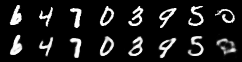

====> Test set loss: 68.5261
Sample of generated images


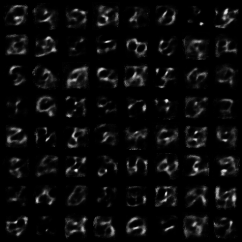



Train Epoch: 10 [0/60000 (0%)]	Loss: 70.360352
Train Epoch: 10 [12800/60000 (21%)]	Loss: 67.311325
Train Epoch: 10 [25600/60000 (43%)]	Loss: 67.972778
Train Epoch: 10 [38400/60000 (64%)]	Loss: 67.062416
Train Epoch: 10 [51200/60000 (85%)]	Loss: 71.945908
====> Epoch: 10 Average loss: 68.3519
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


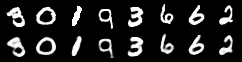

====> Test set loss: 68.0788
Sample of generated images


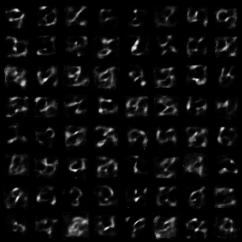



Train Epoch: 1 [0/60000 (0%)]	Loss: 550.767212
Train Epoch: 1 [12800/60000 (21%)]	Loss: 174.807678
Train Epoch: 1 [25600/60000 (43%)]	Loss: 133.054901
Train Epoch: 1 [38400/60000 (64%)]	Loss: 125.541794
Train Epoch: 1 [51200/60000 (85%)]	Loss: 111.932556
====> Epoch: 1 Average loss: 149.5409
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


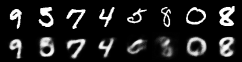

====> Test set loss: 107.8444
Sample of generated images


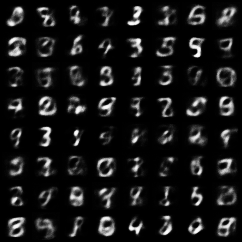



Train Epoch: 2 [0/60000 (0%)]	Loss: 112.616013
Train Epoch: 2 [12800/60000 (21%)]	Loss: 107.770271
Train Epoch: 2 [25600/60000 (43%)]	Loss: 103.424423
Train Epoch: 2 [38400/60000 (64%)]	Loss: 97.387138
Train Epoch: 2 [51200/60000 (85%)]	Loss: 93.573692
====> Epoch: 2 Average loss: 99.0650
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


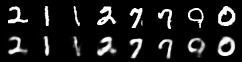

====> Test set loss: 91.3606
Sample of generated images


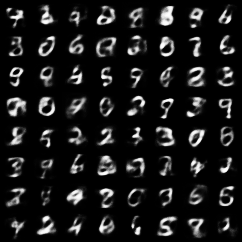



Train Epoch: 3 [0/60000 (0%)]	Loss: 92.254166
Train Epoch: 3 [12800/60000 (21%)]	Loss: 95.330162
Train Epoch: 3 [25600/60000 (43%)]	Loss: 88.985619
Train Epoch: 3 [38400/60000 (64%)]	Loss: 90.422775
Train Epoch: 3 [51200/60000 (85%)]	Loss: 87.234215
====> Epoch: 3 Average loss: 90.3654
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


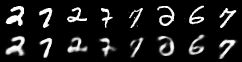

====> Test set loss: 87.6559
Sample of generated images


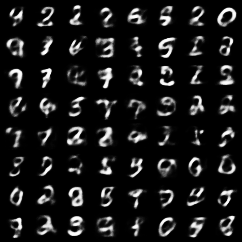



Train Epoch: 4 [0/60000 (0%)]	Loss: 92.334343
Train Epoch: 4 [12800/60000 (21%)]	Loss: 90.319221
Train Epoch: 4 [25600/60000 (43%)]	Loss: 90.662811
Train Epoch: 4 [38400/60000 (64%)]	Loss: 87.459473
Train Epoch: 4 [51200/60000 (85%)]	Loss: 87.233292
====> Epoch: 4 Average loss: 86.8378
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


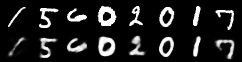

====> Test set loss: 83.9950
Sample of generated images


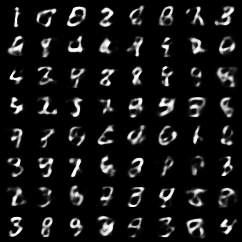



Train Epoch: 5 [0/60000 (0%)]	Loss: 85.108589
Train Epoch: 5 [12800/60000 (21%)]	Loss: 81.830811
Train Epoch: 5 [25600/60000 (43%)]	Loss: 86.628845
Train Epoch: 5 [38400/60000 (64%)]	Loss: 89.820831
Train Epoch: 5 [51200/60000 (85%)]	Loss: 83.737366
====> Epoch: 5 Average loss: 84.8179
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


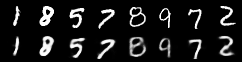

====> Test set loss: 83.3204
Sample of generated images


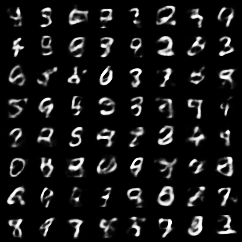



Train Epoch: 6 [0/60000 (0%)]	Loss: 83.597206
Train Epoch: 6 [12800/60000 (21%)]	Loss: 89.676575
Train Epoch: 6 [25600/60000 (43%)]	Loss: 83.492218
Train Epoch: 6 [38400/60000 (64%)]	Loss: 82.455742
Train Epoch: 6 [51200/60000 (85%)]	Loss: 83.633514
====> Epoch: 6 Average loss: 83.5614
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


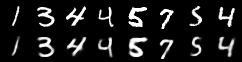

====> Test set loss: 82.4346
Sample of generated images


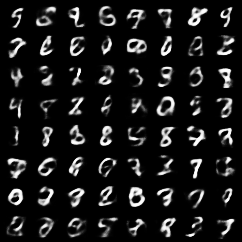



Train Epoch: 7 [0/60000 (0%)]	Loss: 84.242561
Train Epoch: 7 [12800/60000 (21%)]	Loss: 81.484985
Train Epoch: 7 [25600/60000 (43%)]	Loss: 84.201630
Train Epoch: 7 [38400/60000 (64%)]	Loss: 80.694443
Train Epoch: 7 [51200/60000 (85%)]	Loss: 83.072861
====> Epoch: 7 Average loss: 82.5416
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


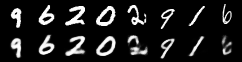

====> Test set loss: 81.3433
Sample of generated images


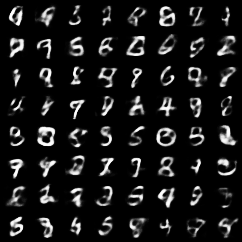



Train Epoch: 8 [0/60000 (0%)]	Loss: 80.873299
Train Epoch: 8 [12800/60000 (21%)]	Loss: 81.508270
Train Epoch: 8 [25600/60000 (43%)]	Loss: 84.514099
Train Epoch: 8 [38400/60000 (64%)]	Loss: 82.621986
Train Epoch: 8 [51200/60000 (85%)]	Loss: 84.826508
====> Epoch: 8 Average loss: 81.8603
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


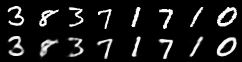

====> Test set loss: 80.6441
Sample of generated images


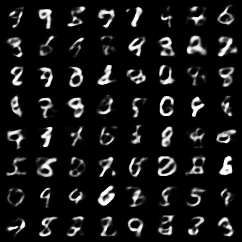



Train Epoch: 9 [0/60000 (0%)]	Loss: 86.249557
Train Epoch: 9 [12800/60000 (21%)]	Loss: 78.835419
Train Epoch: 9 [25600/60000 (43%)]	Loss: 78.368111
Train Epoch: 9 [38400/60000 (64%)]	Loss: 80.445045
Train Epoch: 9 [51200/60000 (85%)]	Loss: 79.066406
====> Epoch: 9 Average loss: 81.2846
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


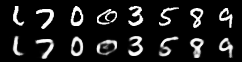

====> Test set loss: 80.6536
Sample of generated images


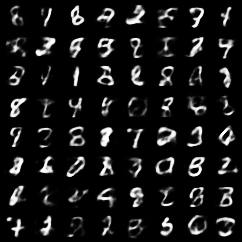



Train Epoch: 10 [0/60000 (0%)]	Loss: 79.178986
Train Epoch: 10 [12800/60000 (21%)]	Loss: 82.915970
Train Epoch: 10 [25600/60000 (43%)]	Loss: 82.515945
Train Epoch: 10 [38400/60000 (64%)]	Loss: 80.058685
Train Epoch: 10 [51200/60000 (85%)]	Loss: 82.142944
====> Epoch: 10 Average loss: 80.8073
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


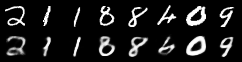

====> Test set loss: 80.7806
Sample of generated images


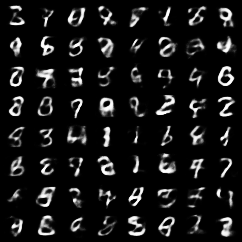

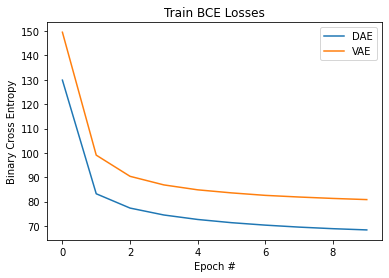

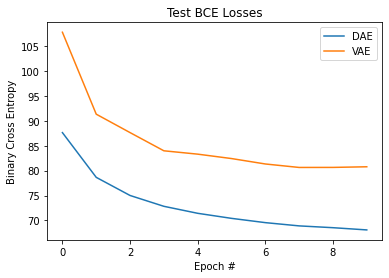

In [17]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

As we can see in the loss graphs, DAE has lower loss than VAE. note that these plots show loss for reconstruction task. it makes sense since DAE uses a deterministic approach to reconstruct the original sample while in VAE we introduce randomness via probabilistic approach to our model which makes reconstruction less accurate. using normal distribution in VAE brings some states into our model which are different from states in our real dataset therefore these data makes it harder for our model to reconstruct original sample. in case of reconstruction,encoded space of DAE is distincs clusters for each data and therefore decoding would be easy since
the goal is reconstructing same datas.

On the other hand we can see that quality of generated images is better in case of VAE. 

In case of generative model, we want to randomly  take samples from the latent space, or produce  some variations on input data from a continuous latent-space. In case of generation , one problem with DAE is that the latent space where they convert their inputs to, may not be continuous therefore interpolation will not be possible and therefore decoder will generate unrealistic output.

latent spaces of VAE are continuous and they  allow us to  easily sample randomly and do interpolation. we achieve this by generating two vectors from encoder for mean and variance. the mean indicates where the encoding of an input data  should be centered around.
variance indicate the interval that encoding can vary. This allows decoder to learn that not only just a  single point but also points that are nearby refer to the same sample. Therefore our generation will be more realistic and we would be able to interpolate on variation of input data.  

